In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from keras import Model, Sequential, layers, regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.regularizers import l2
import pickle
import os

In [2]:
# Define the file path
file_path = '../raw_data/london_real_estate_data.zip'

# Load the data
df = pd.read_csv(file_path, compression='zip')

# Display the first few rows of the dataframe
df.head()

,price,date,postcode,property_type,property_age,ground,number,additional_info,street,locality,town,district,county,year,month,day
0,62750,95-10-02 00:00,BR3 4AT,T,N,F,56,NaN,EDEN ROAD,BECKENHAM,BECKENHAM,BROMLEY,GREATER LONDON,1995,10,2
1,78000,95-09-29 00:00,SW16 3BL,S,N,F,208,NaN,GREEN LANE,LONDON,LONDON,CROYDON,GREATER LONDON,1995,9,29
2,51000,95-10-31 00:00,UB5 5LH,S,N,F,57,NaN,BENGARTH ROAD,NORTHOLT,NORTHOLT,EALING,GREATER LONDON,1995,10,31
3,405000,95-04-07 00:00,N1 2JU,S,N,F,49,NaN,CANONBURY PARK NORTH,LONDON,LONDON,ISLINGTON,GREATER LONDON,1995,4,7
4,60000,95-12-21 00:00,IG1 1PP,T,N,F,209,NaN,HAMPTON ROAD,ILFORD,ILFORD,REDBRIDGE,GREATER LONDON,1995,12,21


In [3]:
df.fillna({'additional_info':''}, inplace=True)

    # merging number and additional number
df['full_property_number']=df['number']+ '' + df['additional_info']

    # dropping columns
df.drop(columns=['number', 'additional_info', 'locality','town','county'], inplace=True)

df.rename(columns={'district':'borough'}, inplace=True)

In [4]:
df.head()

,price,date,postcode,property_type,property_age,ground,street,borough,year,month,day,full_property_number
0,62750,95-10-02 00:00,BR3 4AT,T,N,F,EDEN ROAD,BROMLEY,1995,10,2,56
1,78000,95-09-29 00:00,SW16 3BL,S,N,F,GREEN LANE,CROYDON,1995,9,29,208
2,51000,95-10-31 00:00,UB5 5LH,S,N,F,BENGARTH ROAD,EALING,1995,10,31,57
3,405000,95-04-07 00:00,N1 2JU,S,N,F,CANONBURY PARK NORTH,ISLINGTON,1995,4,7,49
4,60000,95-12-21 00:00,IG1 1PP,T,N,F,HAMPTON ROAD,REDBRIDGE,1995,12,21,209


In [7]:
df.shape

(3623319, 9)

In [8]:
# #work on 5000 sample
df_sampled= df.sample(n=20000,random_state=1 )
df_sampled.shape

(20000, 9)

In [9]:
df_sampled.head()

,price,date,postcode,property_type,property_age,ground,year,month,day
353618,405000,97-08-29 00:00,W5 3SD,S,N,F,1997,8,29
555681,65000,99-08-06 00:00,DA17 5DD,T,N,F,1999,8,6
1625250,160000,05-09-30 00:00,KT4 8LN,T,N,F,2005,9,30
2746490,208000,15-03-12 00:00,E6 2EN,F,N,L,2015,3,12
1644336,205000,05-09-23 00:00,KT6 4EA,F,N,L,2005,9,23


In [10]:
y = df_sampled["price"]
X = df_sampled.drop(columns=["price"])
#remove whitespace 
X.columns = X.columns.str.strip() 
#remove columns with NAN values in their names
X = X.loc[:, ~pd.isna(X.columns)]

In [11]:
# Why Log: Predicting the absolute price of an asset (like real estate) is challenging
# because the model needs to remember the prices from previous time steps accurately. 
# By using log returns instead of absolute prices, we transform the task into predicting the relative change in prices over time, which simplifies the problem.
df_sampled['log_return'] = np.log(df_sampled['price'] / df_sampled['price'].shift(1))
df_sampled = df_sampled.dropna(subset=['log_return'])

# Target and features
y = df_sampled['log_return']
X = df_sampled.drop(columns=['log_return', 'price'])

numeric_columns = ['year', 'month', 'day']
categorical_columns = ['postcode', 'property_type', 'property_age', 'ground']

# Preprocessing pipelines for numerical and categorical data
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer to preprocess both numerical and categorical data
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

# Transform the data
X_transformed = preprocessor.fit_transform(X)

#converting to dense format
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()


# train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes to ensure correct splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (15999, 17542)
X_val shape: (2000, 17542)
X_test shape: (2000, 17542)
y_train shape: (15999,)
y_val shape: (2000,)
y_test shape: (2000,)


In [13]:
# Model 
def build_dense_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1))  # Output layer
    return model

input_shape = (X_train.shape[1],)
model = build_dense_model(input_shape)


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

In [ ]:
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the predictions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

NameError: name 'model' is not defined

In [ ]:
#Test and predict
postcode_example = 'N1 2JU'
sample_data = {
    'year': [2022],
    'month': [6],
    'day': [21],
    'postcode': [postcode_example],
    'property_type': ['F'],
    'property_age': ['N'],
    'ground': ['F']
}

sample_df = pd.DataFrame(sample_data)

# Transform the sample data using the preprocessor
sample_transformed = preprocessor.transform(sample_df)

# Make a prediction
prediction_log_return = model.predict(sample_transformed).flatten()[0]

# Convert log return to actual price
initial_price = df[df['postcode'] == postcode_example]['price'].iloc[-1]
predicted_price = initial_price * np.exp(prediction_log_return)

print(f"Predicted price for postcode {postcode_example}: {predicted_price}")

1/1 [==============================] - 0s 104ms/step
Predicted price for postcode N1 2JU: 1367820.0895786285


63/63 [==============================] - 0s 3ms/step
Length of y_pred_rescaled: 2000
Length of y_test_rescaled: 2000


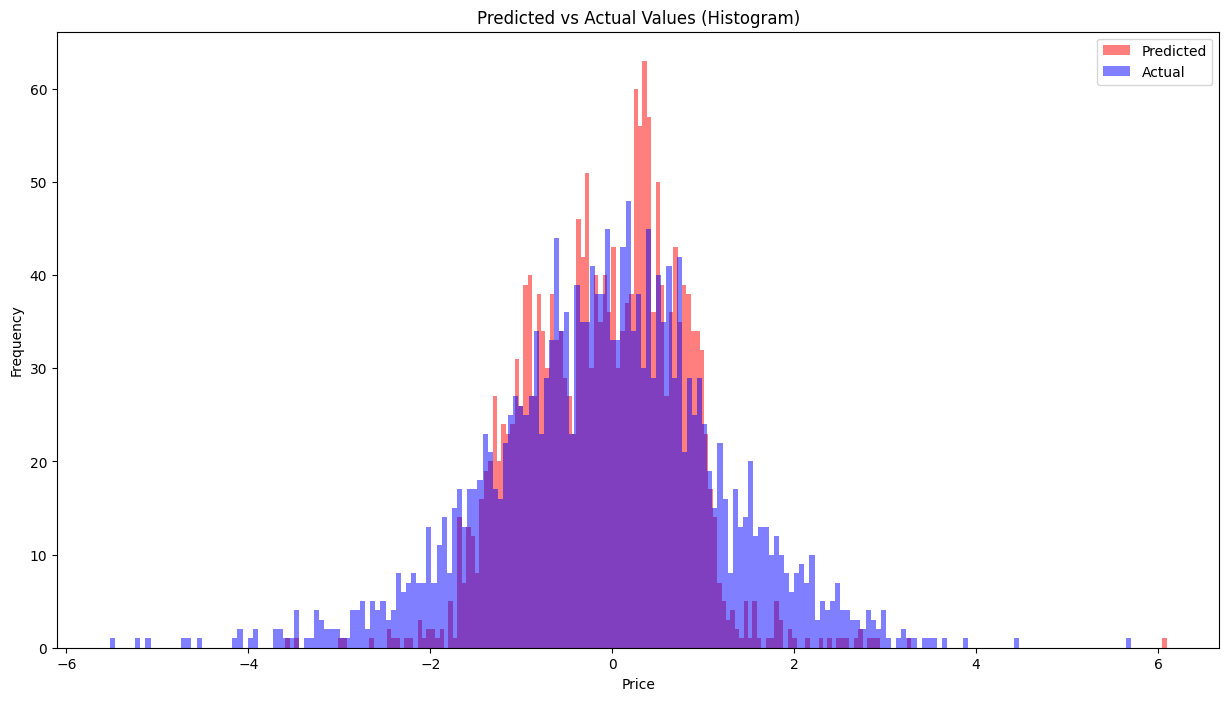

In [ ]:
#Scale target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


# Make predictions on the test set
y_pred = model.predict(X_test).flatten()

# Rescale the predictions and actual test values
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

# Check the lengths to ensure they match
print(f"Length of y_pred_rescaled: {len(y_pred_rescaled)}")
print(f"Length of y_test_rescaled: {len(y_test_rescaled)}")

# Plot histograms of predicted vs actual values
plt.figure(figsize=(15, 8))
plt.hist(y_pred_rescaled, bins=200, alpha=0.5, label='Predicted', color='red')
plt.hist(y_test_rescaled, bins=200, alpha=0.5, label='Actual', color='blue')
plt.legend()
plt.title('Predicted vs Actual Values (Histogram)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Cross_validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []
rmse_scores = []

for train_index, val_index in kf.split(X_transformed):
    X_train, X_val = X_transformed[train_index], X_transformed[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = build_dense_model((X_train.shape[1],))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

    y_pred = model.predict(X_val).flatten()
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae_scores.append(mae)
    rmse_scores.append(rmse)

print(f"Cross-Validation MAE: {np.mean(mae_scores)})")
print(f"Cross-Validation RMSE: {np.mean(rmse_scores)})")

125/125 [==============================] - 1s 4ms/step
Cross-Validation MAE: 0.8593877651799555 (+/- 0.0038928446085258407)
Cross-Validation RMSE: 1.1295697864870287 (+/- 0.006418451106440381)


In [ ]:
y_pred_test = model.predict(X_test).flatten()
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Test Set MAE: {mae_test}")
print(f"Test Set RMSE: {rmse_test}")

63/63 [==============================] - 0s 2ms/step
Test Set MAE: 0.14889250363240872
Test Set RMSE: 0.2130714416614219


In [ ]:
import pickle

# Save the preprocessor and model to a pickle file
model_file_path = '../models/best_model.pkl'
with open(model_file_path, 'wb') as file:
    pickle.dump((preprocessor, model), file)

# Load the preprocessor and model from the pickle file to test
with open(model_file_path, 'rb') as file:
    loaded_preprocessor, loaded_model = pickle.load(file)



NameError: name 'preprocessor' is not defined

In [ ]:
#2